# Explainable Neural Networks

## Table of Contents
1. [Clear Cache](#clearcache)
2. [Dependencies](#dependencies)
3. [Constants](#constants)
4. [Wrangling](#wrangling)
5. [Preprocessing](#preprocessing)
6. [Huggingface + Lightning Module](#hflightningmod)
7. [Lightning Module](#lightningmod)
8. [Explainability](#explainability)

## Clear Cache <a id="clearcache"></a>
Before running this notebook, consider clearing your GPU memory cache by executing the cell block below.

In [1]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info()

(6097534976, 6235422720)

## Dependencies <a id="dependencies"></a>

In [1]:
from captum.attr import IntegratedGradients, NoiseTunnel
from datasets import load_dataset
from datetime import datetime
from lightning.pytorch import Trainer
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import shutil
import sys
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)
from transformers import AutoImageProcessor

sys.path.append("../src")
from models import HFLitImageClassifier, ImageClassifier
from model_utils import fine_tune
from datamodules import HFLitPneumoniaDataModule, PneumoniaDataModule
import visualization as viz

## Constants <a id="constants"></a>

In [2]:
HF_MODEL = "facebook/convnextv2-tiny-1k-224"
TORCH_MODEL = "resnet50"
BATCH_SIZE = 200
IMAGE_SIZE = 224
DATA_DIR = Path.cwd().parent / "data/processed"
MODEL_DIR = Path.cwd().parent / "models"
LOG_DIR = Path.cwd().parent / "logs"
METADATA_FILEPATH = "annotations_file.csv"

In [3]:
CLASS_WEIGHTS = torch.tensor([0.7022, 1.2331, 1.3074]).cuda()

In [35]:
CLASS_WEIGHTS

tensor([0.7022, 1.2331, 1.3074], device='cuda:0')

## Wrangling <a id="wrangling"></a>

In [3]:
n_df = pd.DataFrame({"path": list(Path("../data/raw/normal").glob("*")), "label":"normal"})
b_df = pd.DataFrame({"path": list(Path("../data/raw/bacteria").glob("*")), "label":"bacteria"})
v_df = pd.DataFrame({"path": list(Path("../data/raw/virus").glob("*")), "label":"virus"})
df = b_df.append(n_df).append(v_df)
df.label.value_counts()

/tmp/ipykernel_38483/2371806127.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = b_df.append(n_df).append(v_df)


bacteria    2780
normal      1583
virus       1493
Name: label, dtype: int64

In [8]:
class_weights = compute_class_weight("balanced", classes=df.label.unique(), y=df.label)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(class_weights)

tensor([0.7022, 1.2331, 1.3074])


In [4]:
X_train, X_val, y_train, y_val = train_test_split(df["path"], df["label"], test_size=0.2, stratify=df["label"], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

In [24]:
print(y_train.value_counts(),"\n",y_val.value_counts(),"\n",y_test.value_counts())

bacteria    2224
normal      1266
virus       1194
Name: label, dtype: int64 
 bacteria    278
normal      159
virus       149
Name: label, dtype: int64 
 bacteria    278
normal      158
virus       150
Name: label, dtype: int64


In [5]:
train_df = pd.DataFrame({"in_path":X_train, "label":y_train, "stage":"train"})
val_df = pd.DataFrame({"in_path":X_val, "label":y_val, "stage":"val"})
test_df = pd.DataFrame({"in_path":X_test, "label":y_test, "stage":"test"})

In [6]:
train_df["out_path"] = train_df.apply(lambda x: Path("../data/processed/train")/x["label"]/x["in_path"].name, axis=1)
val_df["out_path"] = val_df.apply(lambda x: Path("../data/processed/val")/x["label"]/x["in_path"].name, axis=1)
test_df["out_path"] = test_df.apply(lambda x: Path("../data/processed/test")/x["label"]/x["in_path"].name, axis=1)
df = train_df.append(val_df).append(test_df)

/tmp/ipykernel_13690/293216600.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train_df.append(val_df).append(test_df)
/tmp/ipykernel_13690/293216600.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train_df.append(val_df).append(test_df)


In [182]:
def copy_files(row):
    os.makedirs(row["out_path"].parent, exist_ok=True)
    shutil.copyfile(row["in_path"], row["out_path"])

In [183]:
df.apply(copy_files, axis=1)

562     None
2011    None
567     None
20      None
1025    None
        ... 
757     None
2511    None
67      None
1238    None
458     None
Length: 5856, dtype: object

In [7]:
df["file_path"] = df["out_path"]
df.drop(columns=["in_path", "out_path"], inplace=True)

In [8]:
df.head()

,label,stage,file_path
562,normal,train,../data/processed/train/normal/NORMAL2-IM-0319...
2011,bacteria,train,../data/processed/train/bacteria/person114_bac...
567,bacteria,train,../data/processed/train/bacteria/person855_bac...
20,normal,train,../data/processed/train/normal/IM-0276-0001.jpeg
1025,normal,train,../data/processed/train/normal/NORMAL2-IM-1198...


In [67]:
df.to_csv("annotations_file.csv", index=False)

In [41]:
dataset = load_dataset("imagefolder", data_dir=DATA_DIR)
dataset

Resolving data files:   0%|          | 0/4684 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/586 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/586 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/matthias/.cache/huggingface/datasets/imagefolder/default-edb636feac3c58d6/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4684
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 586
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 586
    })
})

In [75]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [16]:
# 1 model input consists image pixel tensor and label
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['bacteria', 'normal', 'virus'], id=None)}

In [21]:
# Label mapping
dataset["train"].features["label"]._str2int

{'bacteria': 0, 'normal': 1, 'virus': 2}

In [24]:
# 1 sample
next(iter(dataset["train"]))

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1152x760>,
 'label': 0}

In [31]:
type(next(iter(dataset["train"]))["image"].convert("RGB"))

PIL.Image.Image

## Preprocessing <a id="preprocessing"></a>

In [14]:
image_processor = AutoImageProcessor.from_pretrained(HF_MODEL)

In [16]:
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

In [17]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
        ]
    )

In [22]:
def transforms(examples):
    images = [train_transforms(img.convert("RGB")) for img in examples["image"]]
    examples["pixel_values"] = image_processor(images, do_resize=False, return_tensors="pt")["pixel_values"]
    return examples

In [25]:
dataset.set_transform(transforms)

In [49]:
image_processor

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [59]:
print(
    image_processor.size,
    image_processor.image_mean,
    image_processor.image_std
)

{'shortest_edge': 224} [0.485, 0.456, 0.406] [0.229, 0.224, 0.225]


In [16]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(image_processor.size["shortest_edge"]),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

eval_transforms = Compose(
        [
            Resize(image_processor.size["shortest_edge"]),
            CenterCrop(image_processor.size["shortest_edge"]),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_eval(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [eval_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [17]:
train_ds = dataset["train"]
val_ds = dataset["validation"]
test_ds = dataset["test"]

In [18]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_eval)
test_ds.set_transform(preprocess_eval)

In [19]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_batch_size = BATCH_SIZE
eval_batch_size = 8

train_dataloader = DataLoader(train_ds, shuffle=True, collate_fn=collate_fn, batch_size=train_batch_size)
val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=eval_batch_size)
test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=eval_batch_size)

In [20]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([32, 3, 224, 224])
labels torch.Size([32])


In [108]:
type(batch)

dict

In [105]:
assert batch['pixel_values'].shape == (train_batch_size, 3, 224, 224)
assert batch['labels'].shape == (train_batch_size,)

In [106]:
next(iter(val_dataloader))['pixel_values'].shape

torch.Size([2, 3, 224, 224])

In [107]:
next(iter(test_dataloader))['pixel_values'].shape

torch.Size([2, 3, 224, 224])

## Huggingface + Lightning <a id="hflightningmod"></a>
This section demonstrates the utility of the `HFLitImageClassifier` module. This module facilitates interoperability between Huggingface pre-trained image classifier models and Pytorch Lightning trainers. Specifically, the `Convnextv2` pretrained model was used. The development of this module were motivated by the following factors:
1. Unavailability of Convnextv2 in Torchvision's pre-trained library at the time of developing this project.
2. Personal interest to experiment with the Lightning trainer platform, specifically these features:
    * Auto-logging with a variety of loggers to choose from
    * Quantisation / Mixed precision training
    * Rapid debugging modes (eg. fast_dev_run, overfit_batches, limit_train/val_batches)
    * Abstraction of Pytorch train/val/test/predict loops into callback hooks

### Training & Validation: feature extraction

In [4]:
dm = HFLitPneumoniaDataModule(
    train_batch_size=BATCH_SIZE,
    eval_batch_size=BATCH_SIZE,
    checkpoint=HF_MODEL,
    data_dir=DATA_DIR
)

In [5]:
dm.prepare_data()

Resolving data files:   0%|          | 0/4682 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/586 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/585 [00:00<?, ?it/s]

2023-05-17 23:45:59.536 WARNING datasets.builder: Found cached dataset imagefolder (/home/matthias/.cache/huggingface/datasets/imagefolder/default-3a81d27d2e59c1df/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/3 [00:00<?, ?it/s]

In [32]:
model = HFLitImageClassifier(
    checkpoint=HF_MODEL,
    num_classes=3,
)

Some weights of the model checkpoint at facebook/convnextv2-tiny-1k-224 were not used when initializing ConvNextV2Model: ['convnextv2.encoder.stages.2.layers.4.grn.weight', 'convnextv2.encoder.stages.2.layers.8.grn.weight', 'classifier.bias', 'convnextv2.encoder.stages.2.layers.7.grn.bias', 'convnextv2.encoder.stages.2.layers.1.grn.weight', 'convnextv2.encoder.stages.2.layers.6.grn.weight', 'convnextv2.encoder.stages.2.layers.0.grn.weight', 'convnextv2.encoder.stages.1.layers.1.grn.weight', 'convnextv2.encoder.stages.1.layers.2.grn.weight', 'convnextv2.encoder.stages.3.layers.0.grn.weight', 'convnextv2.encoder.stages.2.layers.5.grn.bias', 'convnextv2.encoder.stages.0.layers.0.grn.weight', 'classifier.weight', 'convnextv2.encoder.stages.3.layers.0.grn.bias', 'convnextv2.encoder.stages.2.layers.2.grn.weight', 'convnextv2.encoder.stages.0.layers.2.grn.weight', 'convnextv2.encoder.stages.3.layers.2.grn.bias', 'convnextv2.encoder.stages.2.layers.8.grn.bias', 'convnextv2.encoder.stages.2.lay

In [ ]:
fine_tune(
    model,
    fine_tune=False
)

In [7]:
curr_dt = datetime.now().strftime("%d%m%Y%H%M")
early_stop_callback = EarlyStopping(
    monitor='valid_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)

lr_logger = LearningRateMonitor()

checkpoint_callback = ModelCheckpoint(
    filename=f"convnextv2_fe_{curr_dt}",
    dirpath=MODEL_DIR,
    save_top_k=1,
    verbose=True,
    monitor="valid_loss",
    mode="min"
)

# tb_logger = pl_loggers.TensorBoardLogger(name="xnn", version=f"featExt_{curr_dt}", save_dir=LOG_DIR/"tensorboard")
mlflow_logger = pl_loggers.MLFlowLogger(
    experiment_name="xnn",
    run_name=f"convnextv2_featExt_{curr_dt}",
    save_dir=LOG_DIR/"mlruns",
    tracking_uri=f"file:{LOG_DIR}/mlruns"
)

trainer = Trainer(
    callbacks=[early_stop_callback],
    logger=[mlflow_logger],
    max_epochs = 20
)
dm.setup(stage="fit")
trainer.fit(model, dm)

In [8]:
trainer.logged_metrics

{'valid_loss': tensor(1.0439),
 'valid_MulticlassAccuracy': tensor(0.4752),
 'valid_MulticlassF1Score': tensor(0.4752),
 'valid_MulticlassAveragePrecision': tensor(0.8619),
 'train_loss': tensor(1.0596),
 'train_MulticlassAccuracy': tensor(0.4748),
 'train_MulticlassF1Score': tensor(0.4748),
 'train_MulticlassAveragePrecision': tensor(0.3602)}

In [9]:
dm.setup(stage="test")
trainer.test(model, dm)

Resolving data files:   0%|          | 0/4682 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/586 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/585 [00:00<?, ?it/s]

2023-05-17 01:26:27.638 WARNING datasets.builder: Found cached dataset imagefolder (/home/matthias/.cache/huggingface/datasets/imagefolder/default-3a81d27d2e59c1df/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/3 [00:00<?, ?it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃           Test metric           ┃          DataLoader 0           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_MulticlassAccuracy     │       0.4744027256965637        │
│ test_MulticlassAveragePrecision │       0.8890266418457031        │
│     test_MulticlassF1Score      │       0.4744027256965637        │
└─────────────────────────────────┴─────────────────────────────────┘

[{'test_MulticlassAccuracy': 0.4744027256965637,
  'test_MulticlassF1Score': 0.4744027256965637,
  'test_MulticlassAveragePrecision': 0.8890266418457031}]

### Tensorboard (Disabled)
Eventually, MLFlow logger was chosen in favour of Tensorboard due to preference for the Experiment-Run paradigm it uses.

%load_ext tensorboard  
%tensorboard --logdir logs/tensorboard/xnn --port 6006

### Fine-tuning

In [11]:
dm = HFLitPneumoniaDataModule(
    train_batch_size=BATCH_SIZE,
    eval_batch_size=BATCH_SIZE,
    checkpoint=HF_MODEL,
    data_dir=DATA_DIR
)

In [22]:
# Ensure to override the learning rate to a lower value than the loaded one
model = HFLitImageClassifier.load_from_checkpoint(
    MODEL_DIR/"convnextv2_fe_200520231618.ckpt",
    learning_rate = 0.0001
)

Some weights of the model checkpoint at facebook/convnextv2-tiny-1k-224 were not used when initializing ConvNextV2Model: ['convnextv2.encoder.stages.2.layers.0.grn.weight', 'classifier.bias', 'convnextv2.encoder.stages.3.layers.2.grn.bias', 'convnextv2.encoder.stages.1.layers.2.grn.weight', 'convnextv2.encoder.stages.1.layers.0.grn.weight', 'convnextv2.encoder.stages.2.layers.0.grn.bias', 'convnextv2.encoder.stages.1.layers.2.grn.bias', 'convnextv2.encoder.stages.1.layers.1.grn.weight', 'convnextv2.encoder.stages.3.layers.0.grn.weight', 'convnextv2.encoder.stages.0.layers.0.grn.bias', 'convnextv2.encoder.stages.2.layers.1.grn.weight', 'convnextv2.encoder.stages.2.layers.6.grn.bias', 'convnextv2.encoder.stages.0.layers.1.grn.bias', 'convnextv2.encoder.stages.0.layers.2.grn.bias', 'convnextv2.encoder.stages.2.layers.4.grn.weight', 'convnextv2.encoder.stages.2.layers.5.grn.bias', 'convnextv2.encoder.stages.2.layers.2.grn.weight', 'convnextv2.encoder.stages.2.layers.8.grn.bias', 'convnextv

In [25]:
fine_tune(
    model,
    fine_tune=True,
    num_layers=10,
    bn_name="norm.weight"
)

In [26]:
curr_dt = datetime.now().strftime("%d%m%Y%H%M")
early_stop_callback = EarlyStopping(
    monitor='valid_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)

lr_logger = LearningRateMonitor()

checkpoint_callback = ModelCheckpoint(
    filename=f"convnextv2_ft_{curr_dt}",
    dirpath=MODEL_DIR,
    save_top_k=1,
    verbose=True,
    monitor="valid_loss",
    mode="min"
)

mlflow_logger = pl_loggers.MLFlowLogger(experiment_name="xnn", run_name=f"convnextv2_fineTune_{curr_dt}", save_dir=LOG_DIR/"mlruns", tracking_uri=f"file:{LOG_DIR}/mlruns")

trainer = Trainer(
    callbacks=[checkpoint_callback, early_stop_callback, lr_logger],
    logger=[mlflow_logger],
    max_epochs = 20
)
dm.prepare_data()
dm.setup(stage="fit")
trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Resolving data files:   0%|          | 0/4682 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/586 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/585 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/matthias/.cache/huggingface/datasets/imagefolder/default-48251635d1f07bf8/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/3 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/4682 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/586 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/585 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/matthias/.cache/huggingface/datasets/imagefolder/default-48251635d1f07bf8/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/3 [00:00<?, ?it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/matthias/projects/ml/Explainable-Neural-Networks/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | body          | ConvNextV2Model  | 27.9 M
1 | classifier    | Sequential       | 11.8 K
2 | train_metrics | MetricCollection | 0     
3 | valid_metrics | MetricCollec

Sanity Checking: 0it [00:00, ?it/s]

/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
Epoch 0, global step 24: 'valid_loss' reached 0.99988 (best 0.99988), saving model to '/home/matthias/projects/ml/Explainable-Neural-Networks/models/convnextv2_ft_250520232032.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
Epoch 1, global step 48: 'valid_loss' reached 0.98730 (best 0.98730), saving model to '/home/matthias/projects/ml/Explainable-Neural-Networks/models/convnextv2_ft_250520232032.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
Epoch 2, global step 72: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
Epoch 3, global step 96: 'valid_loss' reached 0.95948 (best 0.95948), saving model to '/home/matthias/projects/ml/Explainable-Neural-Networks/models/convnextv2_ft_250520232032.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
Epoch 4, global step 120: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
Epoch 5, global step 144: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
Epoch 6, global step 168: 'valid_loss' was not in top 1


Epoch 00007: reducing learning rate of group 0 to 2.0000e-05.


## Lightning Module <a id="lightningmod"></a>
A separate module was also created to work with vanilla Torchvision pre-trained image classifiers. Specifically, both resnet50 and mobilenetv2 were used.

### Training & Validation: feature extraction

In [12]:
dm = PneumoniaDataModule(
    train_batch_size=2,
    eval_batch_size=2,
    data_dir=DATA_DIR,
    image_size=IMAGE_SIZE
)

In [109]:
model = ImageClassifier(
    model_name=TORCH_MODEL,
    num_classes=3,
    learning_rate=0.001
)

In [ ]:
fine_tune(
    model,
    fine_tune=False
)

In [5]:
curr_dt = datetime.now().strftime("%d%m%Y%H%M")
early_stop_callback = EarlyStopping(
    monitor='valid_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)

lr_logger = LearningRateMonitor()

checkpoint_callback = ModelCheckpoint(
    filename=f"resnet_fe_{curr_dt}"
    dirpath=MODEL_DIR,
    save_top_k=1,
    verbose=True,
    monitor="valid_loss",
    mode="min"
)

# tb_logger = pl_loggers.TensorBoardLogger(name="xnn", version=f"featExt_{curr_dt}", save_dir=LOG_DIR/"tensorboard")
mlflow_logger = pl_loggers.MLFlowLogger(experiment_name="xnn", run_name=f"resnet_featExt_{curr_dt}", save_dir=LOG_DIR/"mlruns", tracking_uri=f"file:{LOG_DIR}/mlruns")

trainer = Trainer(
    callbacks=[checkpoint_callback, early_stop_callback, lr_logger],
    logger=[mlflow_logger],
    max_epochs = 2
)
dm.setup(stage="fit")
trainer.fit(model, dm)

In [7]:
trainer.logged_metrics

{'valid_loss': tensor(0.8068),
 'valid_MulticlassAccuracy': tensor(0.6701),
 'valid_MulticlassF1Score': tensor(0.6701),
 'valid_MulticlassAveragePrecision': tensor(0.8078),
 'train_loss': tensor(0.7196),
 'train_MulticlassAccuracy': tensor(0.6988),
 'train_MulticlassF1Score': tensor(0.6988),
 'train_MulticlassAveragePrecision': tensor(0.7136)}

In [8]:
dm.setup(stage="test")
trainer.test(model, dm)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃           Test metric           ┃          DataLoader 0           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_MulticlassAccuracy     │       0.6894198060035706        │
│ test_MulticlassAveragePrecision │       0.8580402731895447        │
│     test_MulticlassF1Score      │       0.6894198060035706        │
└─────────────────────────────────┴─────────────────────────────────┘

[{'test_MulticlassAccuracy': 0.6894198060035706,
  'test_MulticlassF1Score': 0.6894198060035706,
  'test_MulticlassAveragePrecision': 0.8580402731895447}]

### Fine-tuning

In [28]:
dm = PneumoniaDataModule(
    train_batch_size=BATCH_SIZE,
    eval_batch_size=BATCH_SIZE,
    data_dir=DATA_DIR,
    image_size=IMAGE_SIZE
)

In [30]:
# Ensure to override the learning rate to a lower value than the loaded one
model = ImageClassifier.load_from_checkpoint(
    MODEL_DIR/"resnet_fe_200520231303.ckpt",
    learning_rate = 0.0001
)

In [31]:
fine_tune(
    model,
    fine_tune=True,
    num_layers=10,
    bn_name="bn"
)

In [32]:
curr_dt = datetime.now().strftime("%d%m%Y%H%M")
early_stop_callback = EarlyStopping(
    monitor='valid_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)

lr_logger = LearningRateMonitor()

checkpoint_callback = ModelCheckpoint(
    filename=f"resnet_ft_{curr_dt}",
    dirpath=MODEL_DIR,
    save_top_k=1,
    verbose=True,
    monitor="valid_loss",
    mode="min"
)

mlflow_logger = pl_loggers.MLFlowLogger(experiment_name="xnn", run_name=f"resnet_fineTune_{curr_dt}", save_dir=LOG_DIR/"mlruns", tracking_uri=f"file:{LOG_DIR}/mlruns")

trainer = Trainer(
    callbacks=[checkpoint_callback, early_stop_callback, lr_logger],
    logger=[mlflow_logger],
    max_epochs = 20
)

dm.setup(stage="fit")
trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/matthias/projects/ml/Explainable-Neural-Networks/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | body          

Sanity Checking: 0it [00:00, ?it/s]

/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
Epoch 0, global step 24: 'valid_loss' reached 0.53256 (best 0.53256), saving model to '/home/matthias/projects/ml/Explainable-Neural-Networks/models/resnet_ft_250520232103.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
Epoch 1, global step 48: 'valid_loss' reached 0.52862 (best 0.52862), saving model to '/home/matthias/projects/ml/Explainable-Neural-Networks/models/resnet_ft_250520232103.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
Epoch 2, global step 72: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
Epoch 3, global step 96: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

/home/matthias/anaconda3/envs/xnn/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
Epoch 4, global step 120: 'valid_loss' was not in top 1


Epoch 00005: reducing learning rate of group 0 to 2.0000e-05.


## Explainability <a id="explainability"></a>
The fine-tuned Mobilenetv2 model was used as it had the best test performance against Convnextv2 and Resnet50. Integrated Gradients was the chosen explainability algorithm that is called from the Captum library.

### Load model

Load the entire model which defaults to a model on GPU.

In [38]:
# Update the model file with your own
model = ImageClassifier.load_from_checkpoint(MODEL_DIR/"mobilenetv2_ft_200520232038.ckpt")

Or load the model's `state_dict` by mapping the saved model to CPU. This may be useful for dockerisation or running your code on a CPU-only machine. The remainder of this section will be executed using CPU-only mode.

In [3]:
# Update the model file with your own
ckpt = torch.load(MODEL_DIR/"mobilenetv2_ft_200520232038.ckpt", map_location=torch.device("cpu"))

hyperparams = ckpt["hyper_parameters"]
model = ImageClassifier(**hyperparams)

model_weights = ckpt["state_dict"]
model.load_state_dict(model_weights)

In [10]:
model.device

device(type='cpu')

### Initialise datamodule

In [11]:
dm = PneumoniaDataModule(
    image_size=IMAGE_SIZE
)
dm.setup("predict", pred_img_list=[DATA_DIR/"predict/person1954_bacteria_4886.jpeg"])

In [12]:
predict_dl = DataLoader(dm.pred_ds, batch_size=dm.pred_ds.__len__())

### Predict loop

In [14]:
all_logits = []
# Set model to eval mode to turn off norm layer gradients and dropoff layers
model.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(predict_dl):
        logits = model.predict_step(batch, batch_idx)
        all_logits.append(logits)

In [15]:
pred = torch.softmax(logits, dim=1)

In [16]:
prediction_score, pred_label_idx = torch.topk(pred, 1)

In [17]:
print(prediction_score.item(), pred_label_idx.item())

0.5987129807472229 2


### Integrated gradients

In [18]:
integrated_gradients = IntegratedGradients(model)

In [19]:
attributions_ig = integrated_gradients.attribute(batch, target=pred_label_idx.item(), n_steps=50)

It must be noted that Captum's visualization module was copied into `visualization.py` in the `src/` folder and edited to fix a bug involving using an outdate matplotlib argument.

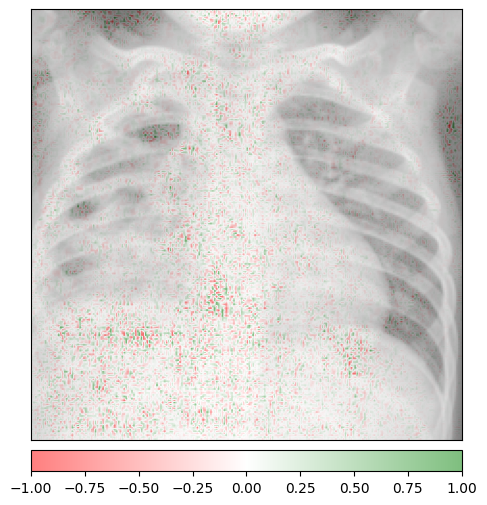

In [21]:
fig, ax = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(batch.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='blended_heat_map',
                             show_colorbar=True,
                             sign='all',
)

The figure above shows green and red pixels, where green pixels contribute positively toward the model's class prediction whilst red pixels contribute negatively to the class prediction.